Using device: cuda
GPT-2 Attention Mechanism Analysis with Gumbel Distribution
Loading GPT-2 model from Hugging Face...
Model loaded successfully!
Hidden size: 768
Number of heads: 12
c_attn weight shape: torch.Size([768, 2304])

=== Analyzing Wq, Wk Weight Distributions ===
c_attn weight shape: (768, 2304)
Expected shape: [768, 2304]
Wq shape: (768, 768)
Wk shape: (768, 768)
Wv shape: (768, 768)
Wq - Mean: 0.000154, Std: 0.238690
Wk - Mean: 0.000012, Std: 0.243296
Wv - Mean: -0.000006, Std: 0.058118


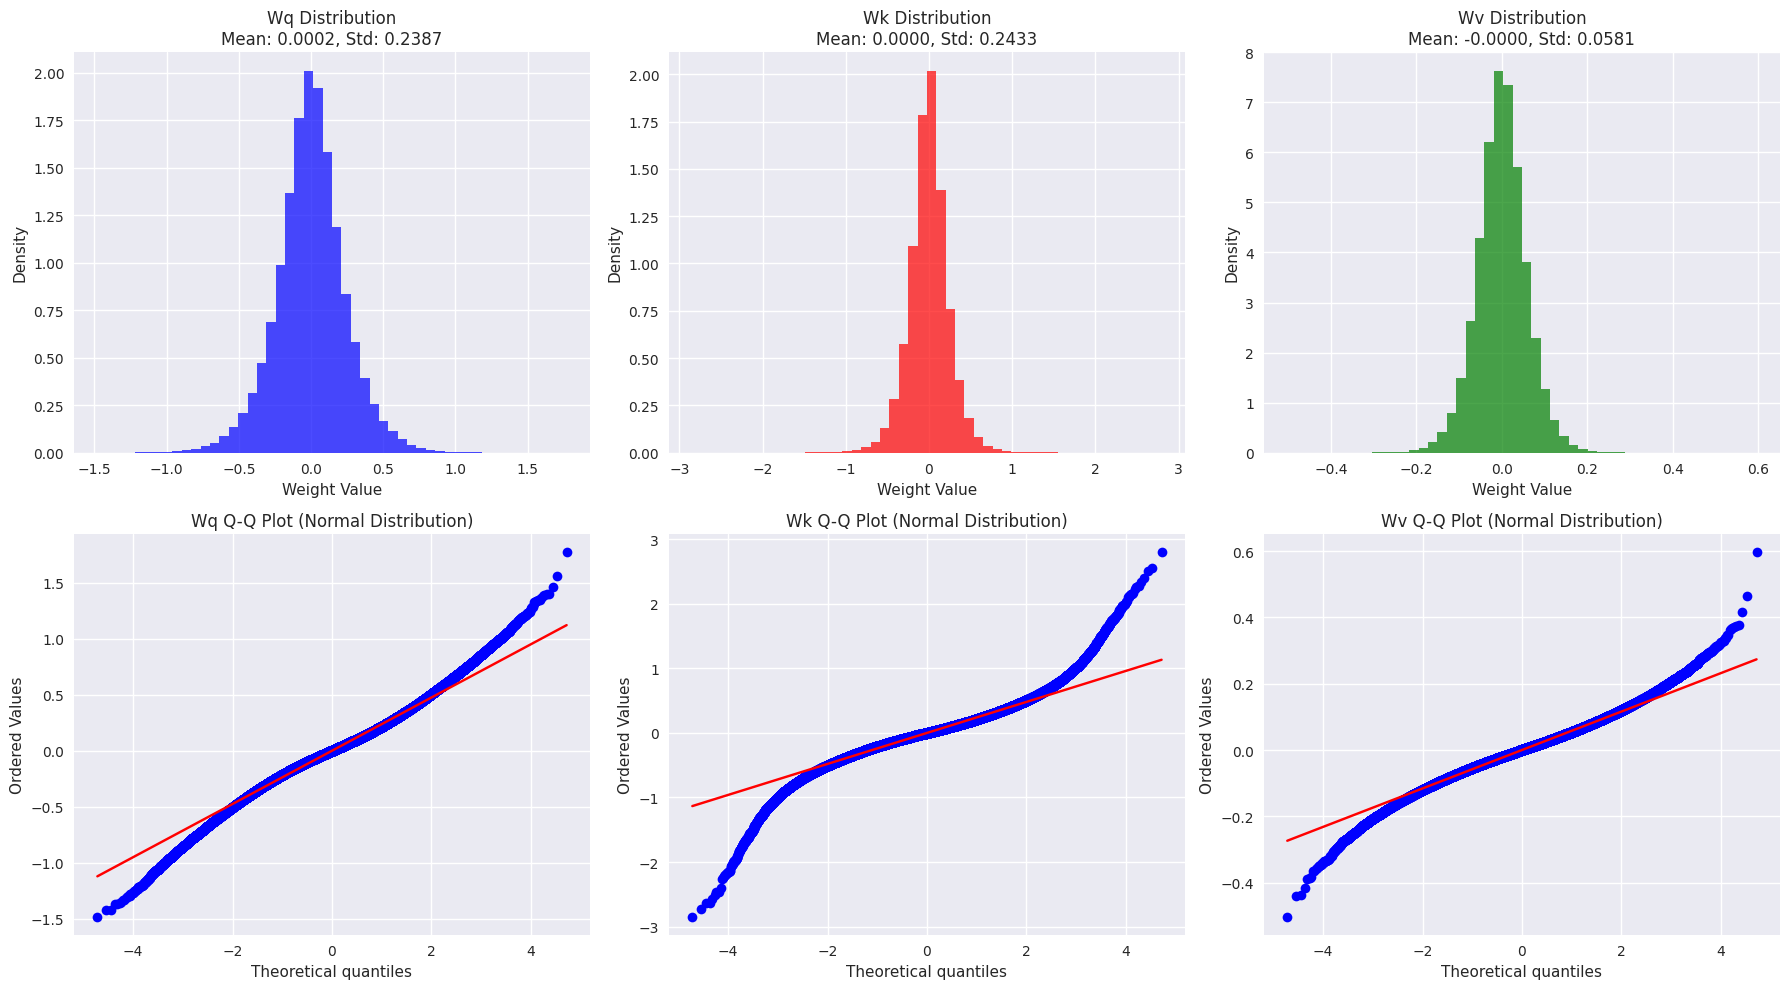


d_k (key dimension per head): 64

=== Theoretical Analysis with Trained Weights ===
Using Wq_std: 0.238690, Wk_std: 0.243296, d_k: 64
Simulated attention logits - Mean: 0.146656, Std: 44.545739
Theoretical attention logits std (approximation): 5.574960

=== Theoretical Analysis with Kaiming Initialization ===
Kaiming initialization std: 0.051031
d_k: 64
Simulated attention logits (Kaiming) - Mean: 0.006180, Std: 1.999330
Theoretical attention logits std (Kaiming): 0.250000

=== Actual Attention Logits Analysis ===
Hidden size: 768
Number of heads: 12
d_k: 64
Processing sample 0/1000
Processing sample 100/1000
Processing sample 200/1000
Processing sample 300/1000
Processing sample 400/1000
Processing sample 500/1000
Processing sample 600/1000
Processing sample 700/1000
Processing sample 800/1000
Processing sample 900/1000
Actual attention logits - Mean: 9.359041, Std: 82.310555
Total logits collected: 1200000

=== Plotting Attention Logits Comparison ===


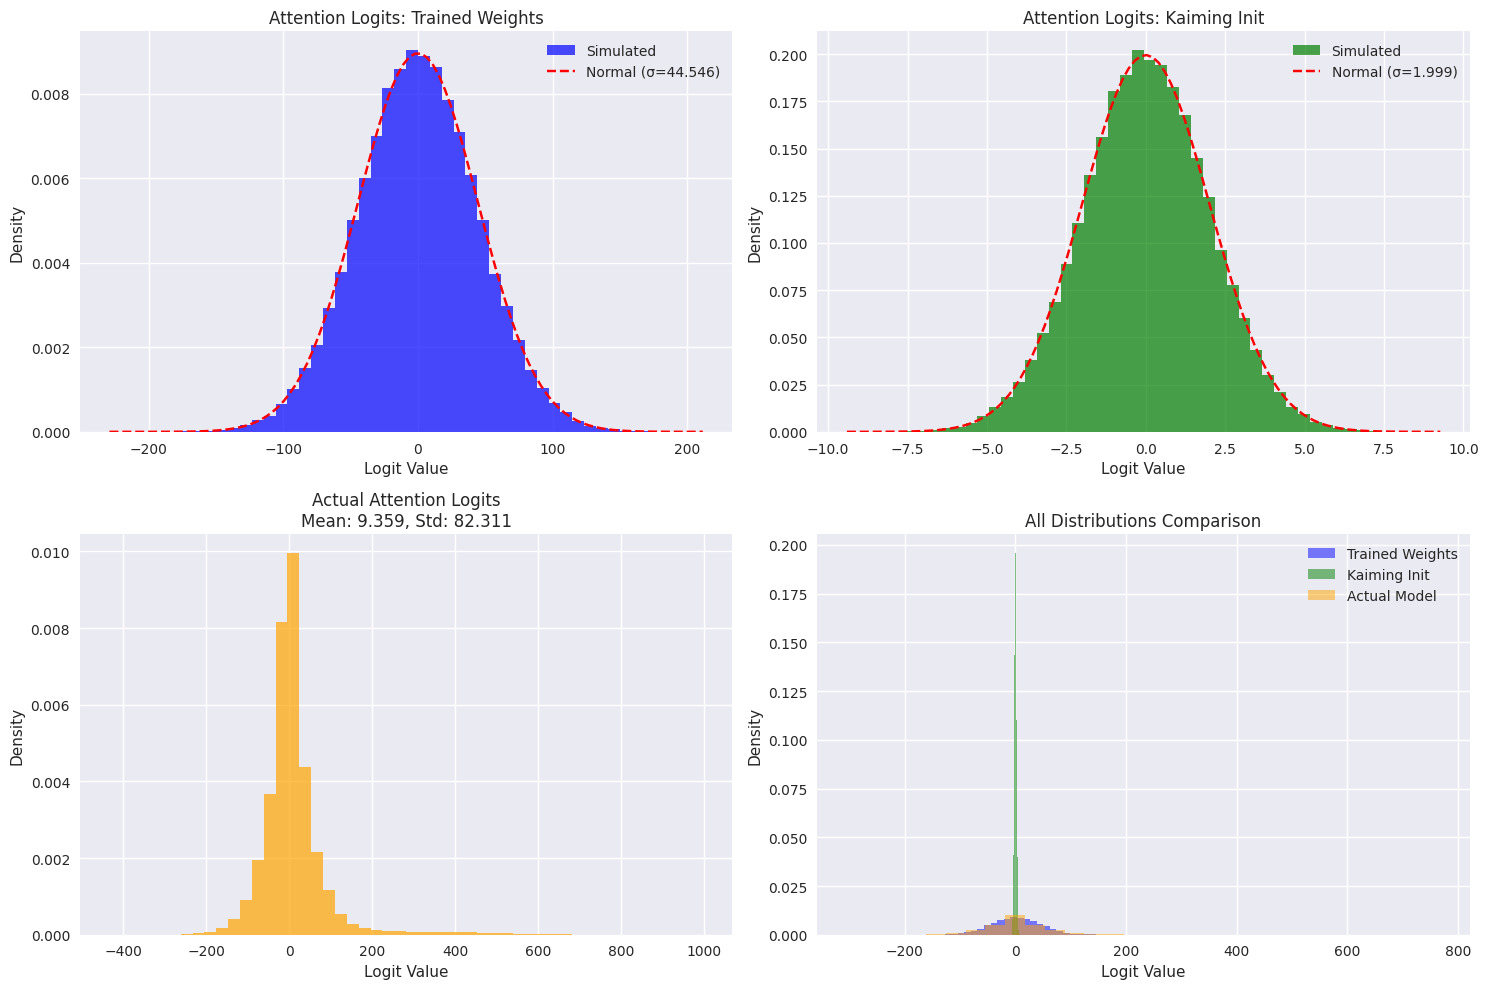


GUMBEL DISTRIBUTION ANALYSIS FOR 99% MAXIMUM ESTIMATION

=== Gumbel Distribution Analysis for Trained Weights ===
Number of blocks: 1000, Block size: 100
Block maxima - Mean: 113.178081, Std: 20.479569
Gumbel parameters - Location (μ): 103.587862, Scale (β): 17.352052
99% percentile (block maxima): 183.409892
99% percentile (adjusted for seq_len=10): 223.364468
99% percentile (Monte Carlo simulation): 140.345663


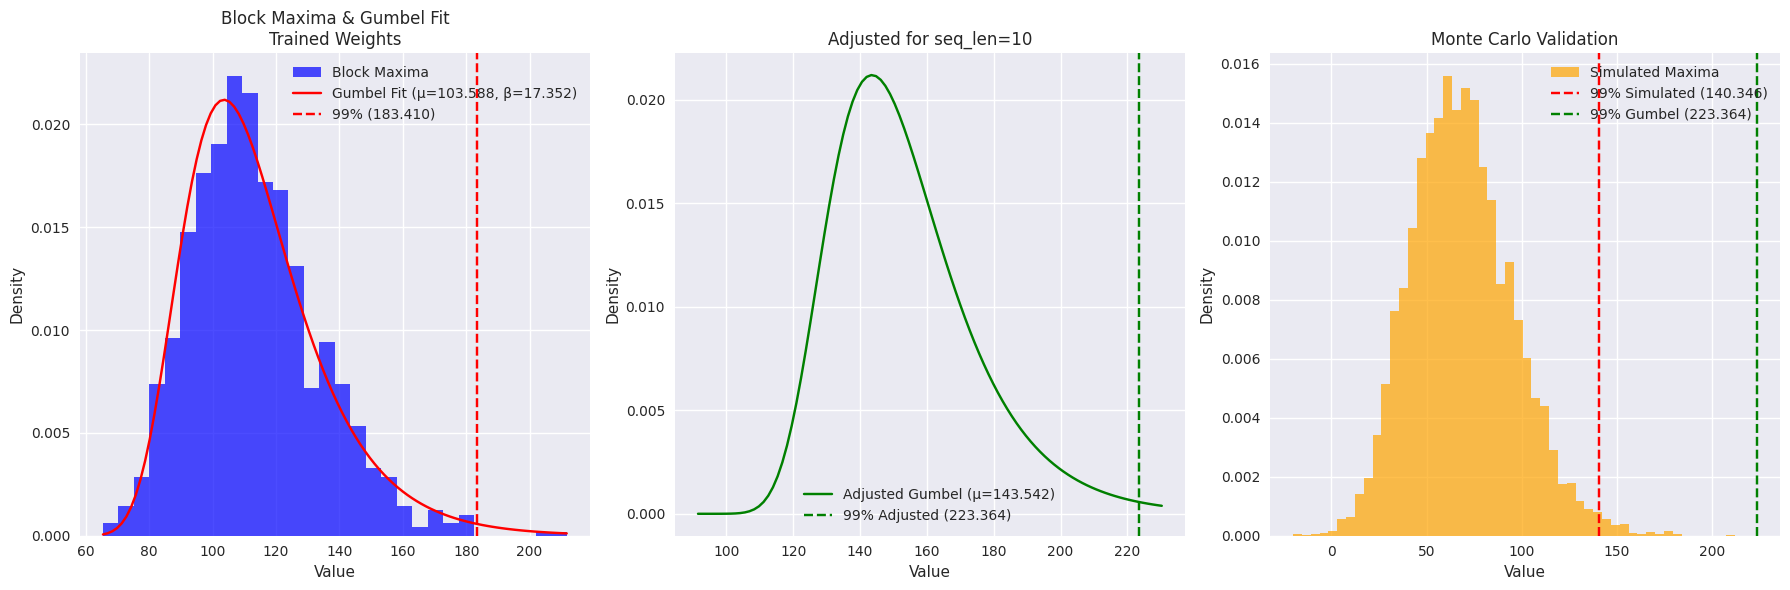


=== Gumbel Distribution Analysis for Kaiming Initialization ===
Number of blocks: 1000, Block size: 100
Block maxima - Mean: 5.058628, Std: 0.912391
Gumbel parameters - Location (μ): 4.631827, Scale (β): 0.764017
99% percentile (block maxima): 8.146421
99% percentile (adjusted for seq_len=10): 9.905636
99% percentile (Monte Carlo simulation): 6.352659


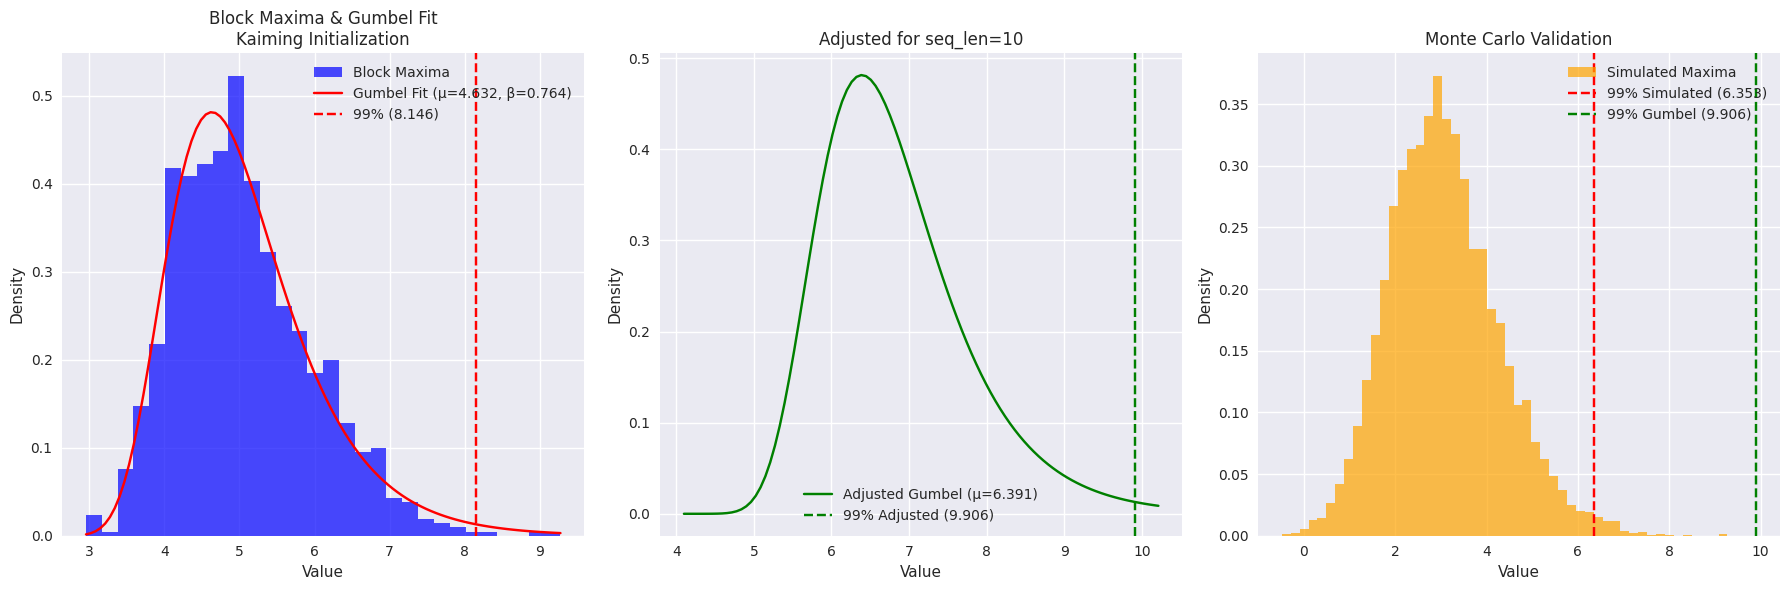


=== Gumbel Distribution Analysis for Actual Model ===
Number of blocks: 1000, Block size: 1200
Block maxima - Mean: 651.986938, Std: 69.635460
Gumbel parameters - Location (μ): 619.613281, Scale (β): 58.684744
99% percentile (block maxima): 889.571861
99% percentile (adjusted for seq_len=10): 1024.698477
99% percentile (Monte Carlo simulation): 616.548218


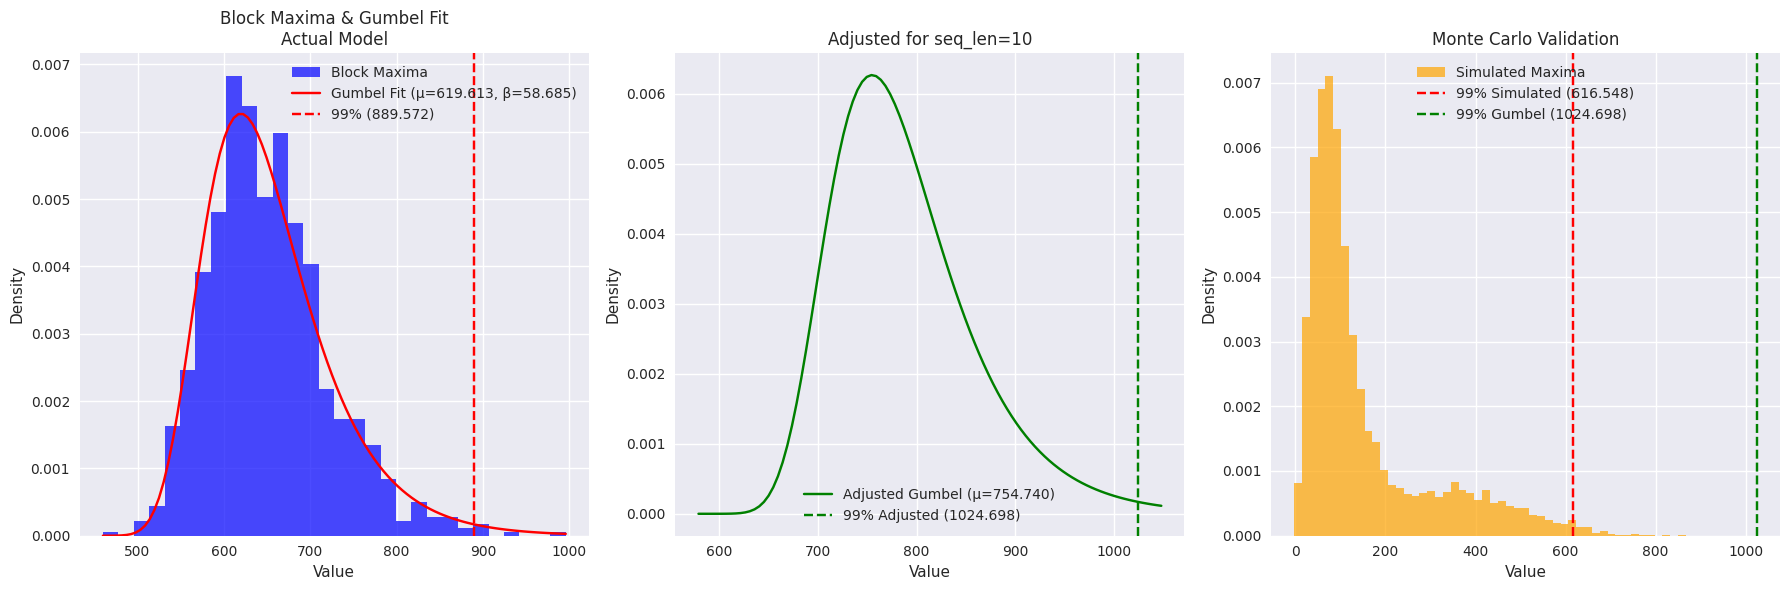


COMPREHENSIVE STATISTICAL SUMMARY
Method               Mean       Std        99% Block    99% Adjusted 99% Simulated
----------------------------------------------------------------------------------------------------
Trained Weights      0.146656   44.545739  183.409892   223.364468   140.345663  
Kaiming Init         0.006180   1.999330   8.146421     9.905636     6.352659    
Actual Model         9.359041   82.310555  889.571861   1024.698477  616.548218  

FINAL SUMMARY: ATTENTION LOGITS MAXIMUM VALUES
For practical applications (e.g., numerical stability), the 99% maximum values are:
- Trained Weights: 223.364468
- Kaiming Init: 9.905636
- Actual Model: 1024.698477


In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2Config
import seaborn as sns
from scipy import stats
from scipy.stats import gumbel_r
import math

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('seaborn-v0_8')

class GPTAnalyzer:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def load_gpt2(self):
        """1. Hugging Face에서 GPT2 불러오기"""
        print("Loading GPT-2 model from Hugging Face...")
        self.model = GPT2Model.from_pretrained('gpt2')
        self.model.to(self.device)
        self.model.eval()

        # 첫 번째 attention layer 가져오기
        self.attention_layer = self.model.h[0].attn
        print(f"Model loaded successfully!")
        print(f"Hidden size: {self.model.config.hidden_size}")
        print(f"Number of heads: {self.model.config.num_attention_heads}")

        # GPT-2 attention layer 구조 확인
        print(f"c_attn weight shape: {self.attention_layer.c_attn.weight.shape}")

    def analyze_wq_wk_distributions(self):
        """2. Wq, Wk 분포 확인 (mean, std, 그래프)"""
        print("\n=== Analyzing Wq, Wk Weight Distributions ===")

        # GPT-2에서는 c_attn이 Wq, Wk, Wv를 concatenated form으로 저장
        # shape: [hidden_size, hidden_size * 3] -> [768, 2304] for GPT-2 base
        c_attn_weight = self.attention_layer.c_attn.weight.data.cpu().numpy()
        hidden_size = self.model.config.hidden_size

        print(f"c_attn weight shape: {c_attn_weight.shape}")
        print(f"Expected shape: [{hidden_size}, {hidden_size * 3}]")

        # GPT-2의 실제 구조: weight는 [hidden_size, 3*hidden_size]
        # 따라서 두 번째 차원을 3개로 분리
        wq = c_attn_weight[:, :hidden_size]              # Query weights [768, 768]
        wk = c_attn_weight[:, hidden_size:2*hidden_size] # Key weights [768, 768]
        wv = c_attn_weight[:, 2*hidden_size:]            # Value weights [768, 768]

        print(f"Wq shape: {wq.shape}")
        print(f"Wk shape: {wk.shape}")
        print(f"Wv shape: {wv.shape}")

        # 통계 계산
        wq_mean, wq_std = np.mean(wq), np.std(wq)
        wk_mean, wk_std = np.mean(wk), np.std(wk)
        wv_mean, wv_std = np.mean(wv), np.std(wv)

        print(f"Wq - Mean: {wq_mean:.6f}, Std: {wq_std:.6f}")
        print(f"Wk - Mean: {wk_mean:.6f}, Std: {wk_std:.6f}")
        print(f"Wv - Mean: {wv_mean:.6f}, Std: {wv_std:.6f}")

        # 그래프 그리기
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        # Wq 히스토그램
        axes[0, 0].hist(wq.flatten(), bins=50, alpha=0.7, density=True, color='blue')
        axes[0, 0].set_title(f'Wq Distribution\nMean: {wq_mean:.4f}, Std: {wq_std:.4f}')
        axes[0, 0].set_xlabel('Weight Value')
        axes[0, 0].set_ylabel('Density')

        # Wk 히스토그램
        axes[0, 1].hist(wk.flatten(), bins=50, alpha=0.7, density=True, color='red')
        axes[0, 1].set_title(f'Wk Distribution\nMean: {wk_mean:.4f}, Std: {wk_std:.4f}')
        axes[0, 1].set_xlabel('Weight Value')
        axes[0, 1].set_ylabel('Density')

        # Wv 히스토그램
        axes[0, 2].hist(wv.flatten(), bins=50, alpha=0.7, density=True, color='green')
        axes[0, 2].set_title(f'Wv Distribution\nMean: {wv_mean:.4f}, Std: {wv_std:.4f}')
        axes[0, 2].set_xlabel('Weight Value')
        axes[0, 2].set_ylabel('Density')

        # Q-Q plot for Wq
        stats.probplot(wq.flatten(), dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title('Wq Q-Q Plot (Normal Distribution)')

        # Q-Q plot for Wk
        stats.probplot(wk.flatten(), dist="norm", plot=axes[1, 1])
        axes[1, 1].set_title('Wk Q-Q Plot (Normal Distribution)')

        # Q-Q plot for Wv
        stats.probplot(wv.flatten(), dist="norm", plot=axes[1, 2])
        axes[1, 2].set_title('Wv Q-Q Plot (Normal Distribution)')

        plt.tight_layout()
        plt.show()

        return wq, wk, wv, wq_mean, wq_std, wk_mean, wk_std

    def estimate_gumbel_max_99(self, data, seq_len, description=""):
        """Gumbel distribution을 사용한 99% 최댓값 추정"""
        print(f"\n=== Gumbel Distribution Analysis for {description} ===")

        # 블록 최댓값 방법 (Block Maxima Method)
        # 데이터를 블록으로 나누고 각 블록의 최댓값을 구함
        block_size = max(100, len(data) // 1000)  # 적절한 블록 크기 설정
        num_blocks = len(data) // block_size

        block_maxima = []
        for i in range(num_blocks):
            start_idx = i * block_size
            end_idx = (i + 1) * block_size
            block_max = np.max(data[start_idx:end_idx])
            block_maxima.append(block_max)

        block_maxima = np.array(block_maxima)
        print(f"Number of blocks: {num_blocks}, Block size: {block_size}")
        print(f"Block maxima - Mean: {np.mean(block_maxima):.6f}, Std: {np.std(block_maxima):.6f}")

        # Gumbel distribution fitting
        gumbel_params = gumbel_r.fit(block_maxima)
        loc, scale = gumbel_params
        print(f"Gumbel parameters - Location (μ): {loc:.6f}, Scale (β): {scale:.6f}")

        # seq_len개 중 최댓값의 분포 추정
        # seq_len개의 독립적인 샘플에서 최댓값
        # 만약 원래 분포가 F(x)라면, 최댓값의 CDF는 F(x)^seq_len

        # 99% 분위수 계산
        percentile_99 = gumbel_r.ppf(0.99, loc, scale)

        # seq_len을 고려한 조정
        # seq_len개 중 최댓값에 대한 Gumbel 분포의 새로운 파라미터
        # 이론적으로: loc_new = loc + scale * ln(seq_len), scale_new = scale
        loc_adjusted = loc + scale * np.log(seq_len)
        percentile_99_adjusted = gumbel_r.ppf(0.99, loc_adjusted, scale)

        print(f"99% percentile (block maxima): {percentile_99:.6f}")
        print(f"99% percentile (adjusted for seq_len={seq_len}): {percentile_99_adjusted:.6f}")

        # 시뮬레이션으로 검증
        simulated_maxima = []
        for _ in range(10000):
            # 원래 분포에서 seq_len개 샘플링하여 최댓값 구하기
            sample_indices = np.random.choice(len(data), seq_len, replace=True)
            sample_values = data[sample_indices]
            simulated_maxima.append(np.max(sample_values))

        simulated_maxima = np.array(simulated_maxima)
        simulated_99 = np.percentile(simulated_maxima, 99)

        print(f"99% percentile (Monte Carlo simulation): {simulated_99:.6f}")

        # 시각화
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # 블록 최댓값 히스토그램과 Gumbel fit
        axes[0].hist(block_maxima, bins=30, alpha=0.7, density=True, color='blue', label='Block Maxima')
        x_range = np.linspace(block_maxima.min(), block_maxima.max(), 100)
        gumbel_pdf = gumbel_r.pdf(x_range, loc, scale)
        axes[0].plot(x_range, gumbel_pdf, 'r-', label=f'Gumbel Fit (μ={loc:.3f}, β={scale:.3f})')
        axes[0].axvline(percentile_99, color='red', linestyle='--', label=f'99% ({percentile_99:.3f})')
        axes[0].set_title(f'Block Maxima & Gumbel Fit\n{description}')
        axes[0].legend()
        axes[0].set_xlabel('Value')
        axes[0].set_ylabel('Density')

        # 조정된 분포 (seq_len 고려)
        x_range_adj = np.linspace(loc_adjusted - 3*scale, loc_adjusted + 5*scale, 100)
        gumbel_pdf_adj = gumbel_r.pdf(x_range_adj, loc_adjusted, scale)
        axes[1].plot(x_range_adj, gumbel_pdf_adj, 'g-', label=f'Adjusted Gumbel (μ={loc_adjusted:.3f})')
        axes[1].axvline(percentile_99_adjusted, color='green', linestyle='--',
                       label=f'99% Adjusted ({percentile_99_adjusted:.3f})')
        axes[1].set_title(f'Adjusted for seq_len={seq_len}')
        axes[1].legend()
        axes[1].set_xlabel('Value')
        axes[1].set_ylabel('Density')

        # 시뮬레이션 결과
        axes[2].hist(simulated_maxima, bins=50, alpha=0.7, density=True, color='orange',
                    label='Simulated Maxima')
        axes[2].axvline(simulated_99, color='red', linestyle='--',
                       label=f'99% Simulated ({simulated_99:.3f})')
        axes[2].axvline(percentile_99_adjusted, color='green', linestyle='--',
                       label=f'99% Gumbel ({percentile_99_adjusted:.3f})')
        axes[2].set_title('Monte Carlo Validation')
        axes[2].legend()
        axes[2].set_xlabel('Value')
        axes[2].set_ylabel('Density')

        plt.tight_layout()
        plt.show()

        return {
            'gumbel_params': (loc, scale),
            'percentile_99_block': percentile_99,
            'percentile_99_adjusted': percentile_99_adjusted,
            'percentile_99_simulated': simulated_99,
            'block_maxima': block_maxima,
            'simulated_maxima': simulated_maxima
        }

    def theoretical_attention_logits_trained(self, wq_std, wk_std, d_k, num_samples=100000):
        """3.1 수학적으로 추정 (훈련된 GPT-2의 Wq, Wk 분포 사용)"""
        print(f"\n=== Theoretical Analysis with Trained Weights ===")
        print(f"Using Wq_std: {wq_std:.6f}, Wk_std: {wk_std:.6f}, d_k: {d_k}")

        hidden_size = self.model.config.hidden_size

        # 시뮬레이션
        attention_logits_sim = []
        for _ in range(num_samples):
            # 입력 벡터 x ~ N(0, 1) [hidden_size]
            x = np.random.normal(0, 1, hidden_size)

            # Wq, Wk 가중치 샘플링 [hidden_size, d_k] (한 헤드만)
            wq_head = np.random.normal(0, wq_std, (hidden_size, d_k))
            wk_head = np.random.normal(0, wk_std, (hidden_size, d_k))

            # q, k 계산 [d_k]
            q = x @ wq_head  # [d_k]
            k = x @ wk_head  # [d_k]

            # attention logit 계산
            attention_logit = np.dot(q, k) / np.sqrt(d_k)
            attention_logits_sim.append(attention_logit)

        attention_logits_sim = np.array(attention_logits_sim)
        simulated_mean = np.mean(attention_logits_sim)
        simulated_std = np.std(attention_logits_sim)

        print(f"Simulated attention logits - Mean: {simulated_mean:.6f}, Std: {simulated_std:.6f}")

        # 이론적 추정 (근사적)
        theoretical_var = (hidden_size * wq_std**2) * (hidden_size * wk_std**2) / d_k
        theoretical_std = np.sqrt(theoretical_var)

        print(f"Theoretical attention logits std (approximation): {theoretical_std:.6f}")

        return attention_logits_sim, simulated_std

    def theoretical_attention_logits_kaiming(self, d_k, num_samples=100000):
        """3.2 수학적으로 추정 (Kaiming init으로 초기화된 Wq, Wk 분포 사용)"""
        print(f"\n=== Theoretical Analysis with Kaiming Initialization ===")

        # Kaiming initialization: std = sqrt(2 / fan_in)
        hidden_size = self.model.config.hidden_size
        kaiming_std = np.sqrt(2.0 / hidden_size)

        print(f"Kaiming initialization std: {kaiming_std:.6f}")
        print(f"d_k: {d_k}")

        # 시뮬레이션
        attention_logits_sim = []
        for _ in range(num_samples):
            # 입력 벡터 x ~ N(0, 1) [hidden_size]
            x = np.random.normal(0, 1, hidden_size)

            # Wq, Wk 가중치 샘플링 (Kaiming initialization)
            wq_head = np.random.normal(0, kaiming_std, (hidden_size, d_k))
            wk_head = np.random.normal(0, kaiming_std, (hidden_size, d_k))

            # q, k 계산
            q = x @ wq_head  # [d_k]
            k = x @ wk_head  # [d_k]

            # attention logit 계산
            attention_logit = np.dot(q, k) / np.sqrt(d_k)
            attention_logits_sim.append(attention_logit)

        attention_logits_kaiming = np.array(attention_logits_sim)
        simulated_mean = np.mean(attention_logits_kaiming)
        simulated_std = np.std(attention_logits_kaiming)

        print(f"Simulated attention logits (Kaiming) - Mean: {simulated_mean:.6f}, Std: {simulated_std:.6f}")

        # 이론적 추정
        theoretical_var = (hidden_size * kaiming_std**2) * (hidden_size * kaiming_std**2) / d_k
        theoretical_std = np.sqrt(theoretical_var)

        print(f"Theoretical attention logits std (Kaiming): {theoretical_std:.6f}")

        return attention_logits_kaiming, simulated_std

    def actual_attention_logits(self, seq_len=10, num_samples=1000):
        """4. 실제 attention logits 분포 확인 (x~N(0,1)이라고 가정)"""
        print(f"\n=== Actual Attention Logits Analysis ===")

        hidden_size = self.model.config.hidden_size
        num_heads = self.model.config.num_attention_heads
        d_k = hidden_size // num_heads

        print(f"Hidden size: {hidden_size}")
        print(f"Number of heads: {num_heads}")
        print(f"d_k: {d_k}")

        attention_logits_list = []

        with torch.no_grad():
            for i in range(num_samples):
                if i % 100 == 0:
                    print(f"Processing sample {i}/{num_samples}")

                # x ~ N(0, 1) 샘플 생성
                x = torch.randn(1, seq_len, hidden_size).to(self.device)

                # attention 계산
                qkv = self.attention_layer.c_attn(x)
                q, k, v = qkv.split(hidden_size, dim=2)

                # multi-head로 reshape
                batch_size = q.size(0)
                q = q.view(batch_size, seq_len, num_heads, d_k).transpose(1, 2)  # [batch, heads, seq, d_k]
                k = k.view(batch_size, seq_len, num_heads, d_k).transpose(1, 2)  # [batch, heads, seq, d_k]

                # attention logits 계산 (scaled dot-product)
                attention_logits = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

                # 모든 헤드의 logits 수집
                for head_idx in range(num_heads):
                    head_logits = attention_logits[0, head_idx].cpu().numpy()
                    # 모든 위치 쌍의 attention logits 수집
                    for i_pos in range(seq_len):
                        for j_pos in range(seq_len):
                            attention_logits_list.append(head_logits[i_pos, j_pos])

        attention_logits_actual = np.array(attention_logits_list)
        actual_mean = np.mean(attention_logits_actual)
        actual_std = np.std(attention_logits_actual)

        print(f"Actual attention logits - Mean: {actual_mean:.6f}, Std: {actual_std:.6f}")
        print(f"Total logits collected: {len(attention_logits_actual)}")

        return attention_logits_actual, d_k

    def plot_attention_logits_comparison(self, logits_trained, logits_kaiming, logits_actual,
                                       std_trained, std_kaiming, seq_len=10):
        """모든 attention logits 분포를 비교하는 그래프"""
        print(f"\n=== Plotting Attention Logits Comparison ===")

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 훈련된 가중치 기반 분포
        axes[0, 0].hist(logits_trained, bins=50, alpha=0.7, density=True, color='blue', label='Simulated')
        # 정규분포 overlay
        x_range = np.linspace(logits_trained.min(), logits_trained.max(), 100)
        theoretical_dist = stats.norm.pdf(x_range, 0, std_trained)
        axes[0, 0].plot(x_range, theoretical_dist, 'r--', label=f'Normal (σ={std_trained:.3f})')
        axes[0, 0].set_title('Attention Logits: Trained Weights')
        axes[0, 0].legend()
        axes[0, 0].set_xlabel('Logit Value')
        axes[0, 0].set_ylabel('Density')

        # Kaiming 초기화 기반 분포
        axes[0, 1].hist(logits_kaiming, bins=50, alpha=0.7, density=True, color='green', label='Simulated')
        x_range = np.linspace(logits_kaiming.min(), logits_kaiming.max(), 100)
        theoretical_dist = stats.norm.pdf(x_range, 0, std_kaiming)
        axes[0, 1].plot(x_range, theoretical_dist, 'r--', label=f'Normal (σ={std_kaiming:.3f})')
        axes[0, 1].set_title('Attention Logits: Kaiming Init')
        axes[0, 1].legend()
        axes[0, 1].set_xlabel('Logit Value')
        axes[0, 1].set_ylabel('Density')

        # 실제 모델 분포
        axes[1, 0].hist(logits_actual, bins=50, alpha=0.7, density=True, color='orange')
        axes[1, 0].set_title(f'Actual Attention Logits\nMean: {np.mean(logits_actual):.3f}, Std: {np.std(logits_actual):.3f}')
        axes[1, 0].set_xlabel('Logit Value')
        axes[1, 0].set_ylabel('Density')

        # 모든 분포 비교
        # 샘플링해서 그리기 (너무 많은 데이터로 인한 성능 이슈 방지)
        sample_size = 10000
        trained_sample = np.random.choice(logits_trained, min(sample_size, len(logits_trained)), replace=False)
        kaiming_sample = np.random.choice(logits_kaiming, min(sample_size, len(logits_kaiming)), replace=False)
        actual_sample = np.random.choice(logits_actual, min(sample_size, len(logits_actual)), replace=False)

        axes[1, 1].hist(trained_sample, bins=30, alpha=0.5, density=True, color='blue', label='Trained Weights')
        axes[1, 1].hist(kaiming_sample, bins=30, alpha=0.5, density=True, color='green', label='Kaiming Init')
        axes[1, 1].hist(actual_sample, bins=30, alpha=0.5, density=True, color='orange', label='Actual Model')
        axes[1, 1].set_title('All Distributions Comparison')
        axes[1, 1].legend()
        axes[1, 1].set_xlabel('Logit Value')
        axes[1, 1].set_ylabel('Density')

        plt.tight_layout()
        plt.show()

        # Gumbel 분석 수행
        print("\n" + "="*80)
        print("GUMBEL DISTRIBUTION ANALYSIS FOR 99% MAXIMUM ESTIMATION")
        print("="*80)

        # 각 분포에 대해 Gumbel 분석
        gumbel_results = {}

        gumbel_results['trained'] = self.estimate_gumbel_max_99(
            logits_trained, seq_len, "Trained Weights")

        gumbel_results['kaiming'] = self.estimate_gumbel_max_99(
            logits_kaiming, seq_len, "Kaiming Initialization")

        gumbel_results['actual'] = self.estimate_gumbel_max_99(
            logits_actual, seq_len, "Actual Model")

        # 통계 요약 테이블
        print("\n" + "="*100)
        print("COMPREHENSIVE STATISTICAL SUMMARY")
        print("="*100)
        print(f"{'Method':<20} {'Mean':<10} {'Std':<10} {'99% Block':<12} {'99% Adjusted':<12} {'99% Simulated':<12}")
        print("-"*100)

        for method, data, results in [
            ('Trained Weights', logits_trained, gumbel_results['trained']),
            ('Kaiming Init', logits_kaiming, gumbel_results['kaiming']),
            ('Actual Model', logits_actual, gumbel_results['actual'])
        ]:
            print(f"{method:<20} {np.mean(data):<10.6f} {np.std(data):<10.6f} "
                  f"{results['percentile_99_block']:<12.6f} {results['percentile_99_adjusted']:<12.6f} "
                  f"{results['percentile_99_simulated']:<12.6f}")

        return gumbel_results

    def run_full_analysis(self):
        """전체 분석 실행"""
        print("="*60)
        print("GPT-2 Attention Mechanism Analysis with Gumbel Distribution")
        print("="*60)

        # 1. GPT-2 모델 로드
        self.load_gpt2()

        # 2. Wq, Wk 분포 분석
        wq, wk, wv, wq_mean, wq_std, wk_mean, wk_std = self.analyze_wq_wk_distributions()

        # d_k 계산
        d_k = self.model.config.hidden_size // self.model.config.num_attention_heads
        print(f"\nd_k (key dimension per head): {d_k}")

        # 3.1 훈련된 가중치 기반 이론적 분석
        logits_trained, std_trained = self.theoretical_attention_logits_trained(
            wq_std, wk_std, d_k)

        # 3.2 Kaiming 초기화 기반 이론적 분석
        logits_kaiming, std_kaiming = self.theoretical_attention_logits_kaiming(d_k)

        # 4. 실제 attention logits 분석
        logits_actual, d_k_actual = self.actual_attention_logits()

        # 5. 모든 결과 비교 시각화 및 Gumbel 분석
        seq_len = 10  # attention sequence length for max estimation
        gumbel_results = self.plot_attention_logits_comparison(
            logits_trained, logits_kaiming, logits_actual,
            std_trained, std_kaiming, seq_len)

        # 6. 최종 요약
        print("\n" + "="*80)
        print("FINAL SUMMARY: ATTENTION LOGITS MAXIMUM VALUES")
        print("="*80)
        print("For practical applications (e.g., numerical stability), the 99% maximum values are:")
        print(f"- Trained Weights: {gumbel_results['trained']['percentile_99_adjusted']:.6f}")
        print(f"- Kaiming Init: {gumbel_results['kaiming']['percentile_99_adjusted']:.6f}")
        print(f"- Actual Model: {gumbel_results['actual']['percentile_99_adjusted']:.6f}")

        return gumbel_results

# 실행
if __name__ == "__main__":
    analyzer = GPTAnalyzer()
    results = analyzer.run_full_analysis()

Using device: cuda
GPT-2 Attention Mechanism Analysis
Loading GPT-2 model from Hugging Face...
Model loaded successfully!
Hidden size: 768
Number of heads: 12
c_attn weight shape: torch.Size([768, 2304])

=== Analyzing Wq, Wk Weight Distributions ===
c_attn weight shape: (768, 2304)
Expected shape: [2304, 768]
Wq shape: (768, 768)
Wk shape: (768, 768)
Wv shape: (768, 768)
Wq - Mean: 0.000154, Std: 0.238690
Wk - Mean: 0.000012, Std: 0.243296
Wv - Mean: -0.000006, Std: 0.058118


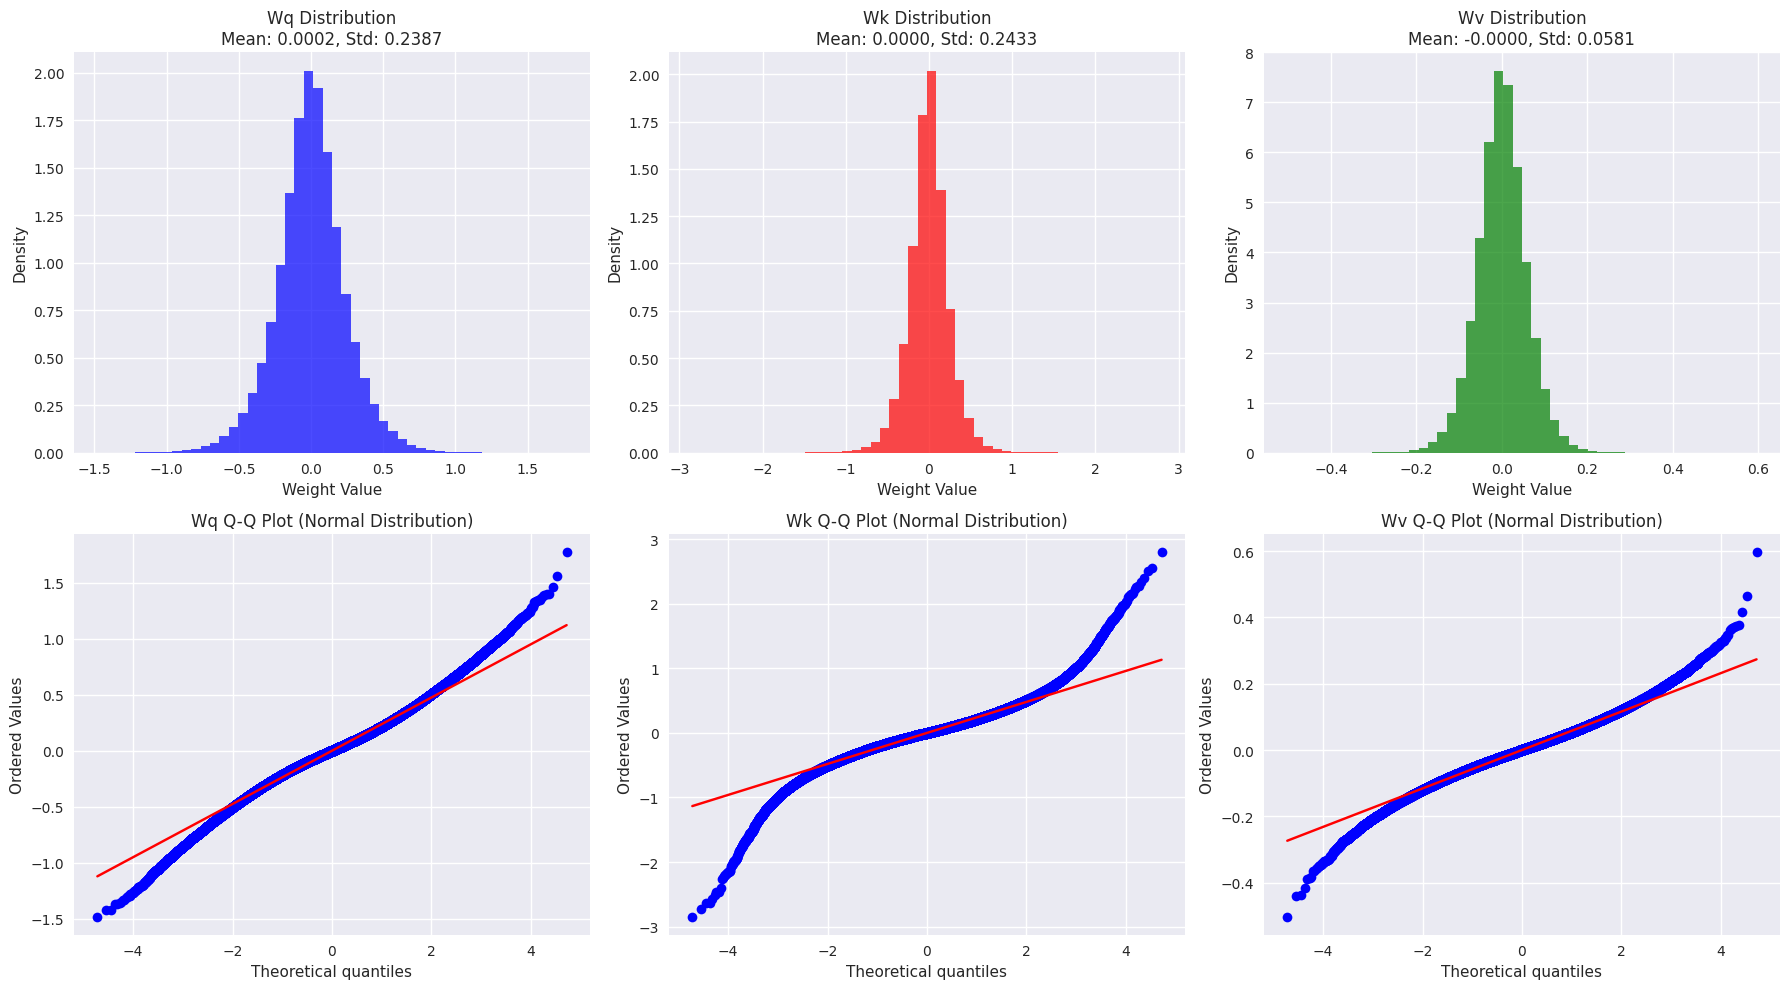


d_k (key dimension per head): 64

=== Theoretical Analysis with Trained Weights ===
Using Wq_std: 0.238690, Wk_std: 0.243296, d_k: 64
Theoretical attention logits std: 0.464580
Simulated attention logits std: 0.100549

=== Theoretical Analysis with Kaiming Initialization ===
Kaiming initialization std: 0.051031
d_k: 64
Theoretical attention logits std (Kaiming): 0.020833
Simulated attention logits std (Kaiming): 0.004456

=== Actual Attention Logits Analysis ===
Hidden size: 768
Number of heads: 12
d_k: 64
Processing sample 0/1000
Processing sample 100/1000
Processing sample 200/1000
Processing sample 300/1000
Processing sample 400/1000
Processing sample 500/1000
Processing sample 600/1000
Processing sample 700/1000
Processing sample 800/1000
Processing sample 900/1000
Actual attention logits - Mean: 16.929907, Std: 100.165565
Total logits collected: 660000

=== Plotting Attention Logits Comparison ===


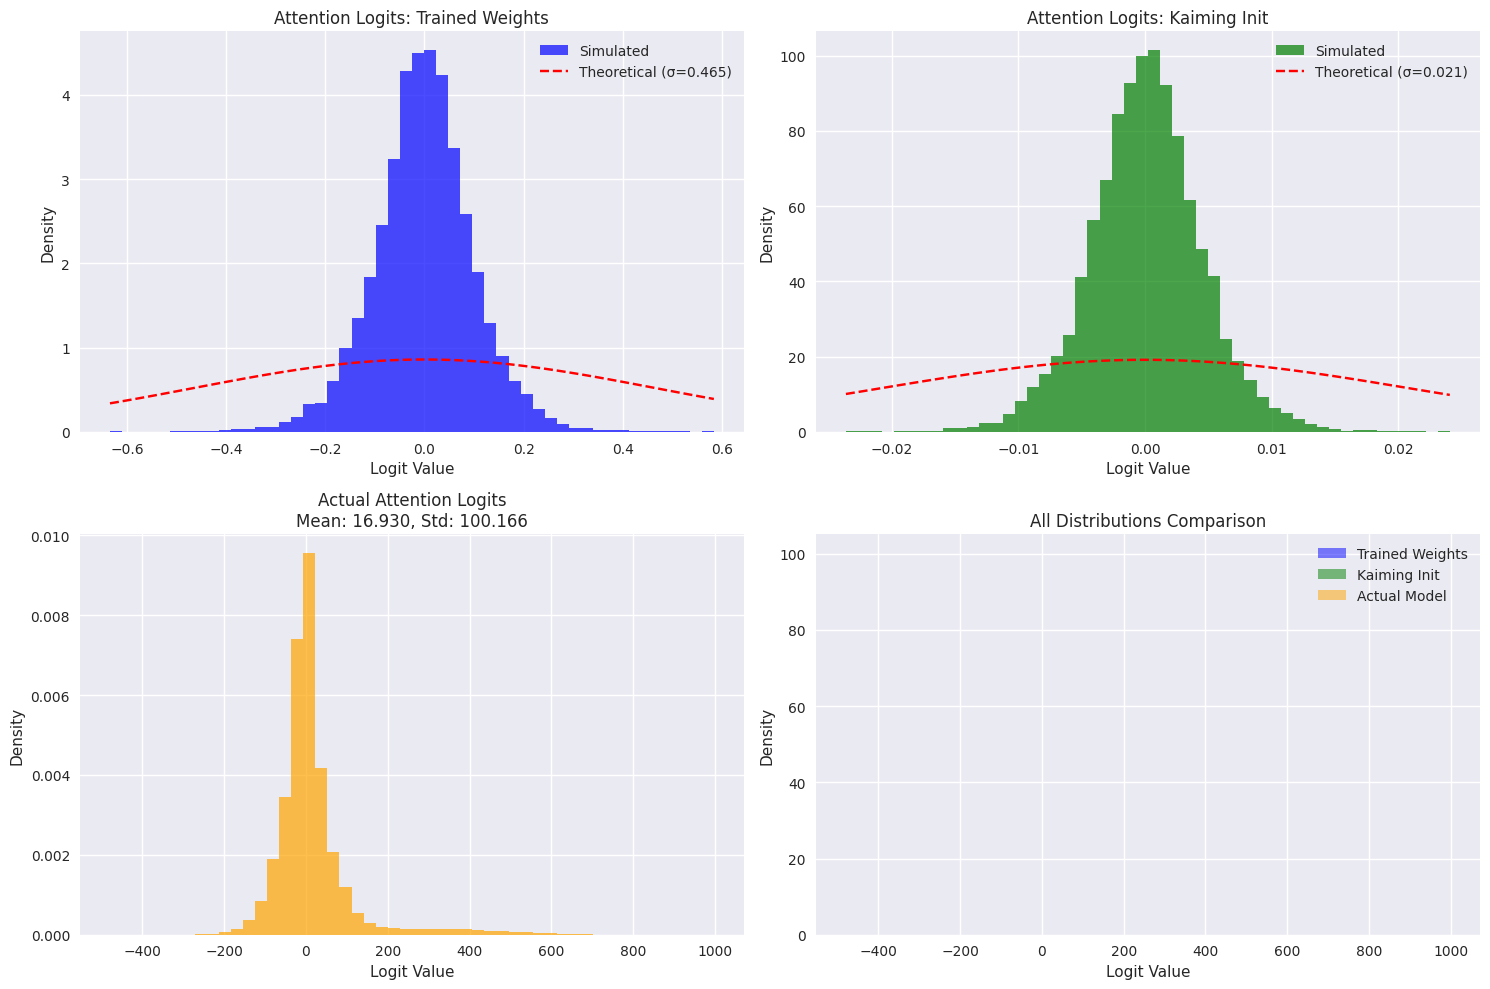


STATISTICAL SUMMARY
Method               Mean       Std        Theoretical Std
--------------------------------------------------------------------------------
Trained Weights      -0.001269  0.100549   0.464580       
Kaiming Init         0.000092   0.004456   0.020833       
Actual Model         16.929907  100.165565 N/A            


In [12]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2Config
import seaborn as sns
from scipy import stats
import math

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('seaborn-v0_8')

class GPTAnalyzer:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def load_gpt2(self):
        """1. Hugging Face에서 GPT2 불러오기"""
        print("Loading GPT-2 model from Hugging Face...")
        self.model = GPT2Model.from_pretrained('gpt2')
        self.model.to(self.device)
        self.model.eval()

        # 첫 번째 attention layer 가져오기
        self.attention_layer = self.model.h[0].attn
        print(f"Model loaded successfully!")
        print(f"Hidden size: {self.model.config.hidden_size}")
        print(f"Number of heads: {self.model.config.num_attention_heads}")

        # GPT-2 attention layer 구조 확인
        print(f"c_attn weight shape: {self.attention_layer.c_attn.weight.shape}")

    def analyze_wq_wk_distributions(self):
        """2. Wq, Wk 분포 확인 (mean, std, 그래프)"""
        print("\n=== Analyzing Wq, Wk Weight Distributions ===")

        # GPT-2에서는 c_attn이 Wq, Wk, Wv를 concatenated form으로 저장
        # shape: [hidden_size * 3, hidden_size] -> [2304, 768] for GPT-2 base
        c_attn_weight = self.attention_layer.c_attn.weight.data.cpu().numpy()
        hidden_size = self.model.config.hidden_size

        print(f"c_attn weight shape: {c_attn_weight.shape}")
        print(f"Expected shape: [{hidden_size * 3}, {hidden_size}]")

        ## GPT-2의 실제 구조: weight는 [hidden_size, 3*hidden_size]
        # 따라서 두 번째 차원을 3개로 분리
        wq = c_attn_weight[:, :hidden_size]              # Query weights [768, 768]
        wk = c_attn_weight[:, hidden_size:2*hidden_size] # Key weights [768, 768]
        wv = c_attn_weight[:, 2*hidden_size:]            # Value weights [768, 768]

        print(f"Wq shape: {wq.shape}")
        print(f"Wk shape: {wk.shape}")
        print(f"Wv shape: {wv.shape}")

        # 통계 계산
        wq_mean, wq_std = np.mean(wq), np.std(wq)
        wk_mean, wk_std = np.mean(wk), np.std(wk)
        wv_mean, wv_std = np.mean(wv), np.std(wv)

        print(f"Wq - Mean: {wq_mean:.6f}, Std: {wq_std:.6f}")
        print(f"Wk - Mean: {wk_mean:.6f}, Std: {wk_std:.6f}")
        print(f"Wv - Mean: {wv_mean:.6f}, Std: {wv_std:.6f}")

        # 그래프 그리기
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        # Wq 히스토그램
        axes[0, 0].hist(wq.flatten(), bins=50, alpha=0.7, density=True, color='blue')
        axes[0, 0].set_title(f'Wq Distribution\nMean: {wq_mean:.4f}, Std: {wq_std:.4f}')
        axes[0, 0].set_xlabel('Weight Value')
        axes[0, 0].set_ylabel('Density')

        # Wk 히스토그램
        axes[0, 1].hist(wk.flatten(), bins=50, alpha=0.7, density=True, color='red')
        axes[0, 1].set_title(f'Wk Distribution\nMean: {wk_mean:.4f}, Std: {wk_std:.4f}')
        axes[0, 1].set_xlabel('Weight Value')
        axes[0, 1].set_ylabel('Density')

        # Wv 히스토그램
        axes[0, 2].hist(wv.flatten(), bins=50, alpha=0.7, density=True, color='green')
        axes[0, 2].set_title(f'Wv Distribution\nMean: {wv_mean:.4f}, Std: {wv_std:.4f}')
        axes[0, 2].set_xlabel('Weight Value')
        axes[0, 2].set_ylabel('Density')

        # Q-Q plot for Wq
        stats.probplot(wq.flatten(), dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title('Wq Q-Q Plot (Normal Distribution)')

        # Q-Q plot for Wk
        stats.probplot(wk.flatten(), dist="norm", plot=axes[1, 1])
        axes[1, 1].set_title('Wk Q-Q Plot (Normal Distribution)')

        # Q-Q plot for Wv
        stats.probplot(wv.flatten(), dist="norm", plot=axes[1, 2])
        axes[1, 2].set_title('Wv Q-Q Plot (Normal Distribution)')

        plt.tight_layout()
        plt.show()

        return wq, wk, wv, wq_mean, wq_std, wk_mean, wk_std

    def theoretical_attention_logits_trained(self, wq_std, wk_std, d_k, num_samples=10000):
        """3.1 수학적으로 추정 (훈련된 GPT-2의 Wq, Wk 분포 사용)"""
        print(f"\n=== Theoretical Analysis with Trained Weights ===")
        print(f"Using Wq_std: {wq_std:.6f}, Wk_std: {wk_std:.6f}, d_k: {d_k}")

        # x ~ N(0, 1)이라고 가정
        # q = x @ Wq, k = x @ Wk (여기서 x는 [seq_len, hidden_size])
        # 각 head에 대해 q, k는 [seq_len, d_k] 크기

        # Single head attention logit = q_i^T @ k_j
        # q_i, k_j는 각각 d_k 차원 벡터
        # q_i = sum(x_l * Wq_l,i) for l in d_k
        # k_j = sum(x_l * Wk_l,j) for l in d_k

        # Var(q_i) ≈ d_k * Var(x) * Var(Wq) = d_k * 1 * wq_std^2
        # Var(k_j) ≈ d_k * Var(x) * Var(Wk) = d_k * 1 * wk_std^2

        # attention_logit = q_i^T @ k_j / sqrt(d_k)
        # 만약 q_i와 k_j가 독립이라면:
        # Var(attention_logit) ≈ Var(q_i) * Var(k_j) / d_k = d_k * wq_std^2 * d_k * wk_std^2 / d_k
        #                      = d_k * wq_std^2 * wk_std^2

        theoretical_var = d_k * (wq_std ** 2) * (wk_std ** 2)
        theoretical_std = np.sqrt(theoretical_var)

        print(f"Theoretical attention logits std: {theoretical_std:.6f}")

        # 시뮬레이션으로 검증
        attention_logits_sim = []
        for _ in range(num_samples):
            # 입력 벡터 x ~ N(0, 1)
            x = np.random.normal(0, 1, d_k)

            # q, k 벡터 생성 (simplified)
            q = np.random.normal(0, wq_std, d_k) * x
            k = np.random.normal(0, wk_std, d_k) * x

            # attention logit 계산
            attention_logit = np.dot(q, k) / np.sqrt(d_k)
            attention_logits_sim.append(attention_logit)

        attention_logits_sim = np.array(attention_logits_sim)
        simulated_std = np.std(attention_logits_sim)
        print(f"Simulated attention logits std: {simulated_std:.6f}")

        return attention_logits_sim, theoretical_std

    def theoretical_attention_logits_kaiming(self, d_k, num_samples=10000):
        """3.2 수학적으로 추정 (Kaiming init으로 초기화된 Wq, Wk 분포 사용)"""
        print(f"\n=== Theoretical Analysis with Kaiming Initialization ===")

        # Kaiming initialization: std = sqrt(2 / fan_in)
        # GPT-2에서 fan_in = hidden_size
        hidden_size = self.model.config.hidden_size
        kaiming_std = np.sqrt(2.0 / hidden_size)

        print(f"Kaiming initialization std: {kaiming_std:.6f}")
        print(f"d_k: {d_k}")

        # 이론적 attention logits 분산
        theoretical_var = d_k * (kaiming_std ** 2) * (kaiming_std ** 2)
        theoretical_std = np.sqrt(theoretical_var)

        print(f"Theoretical attention logits std (Kaiming): {theoretical_std:.6f}")

        # 시뮬레이션
        attention_logits_sim = []
        for _ in range(num_samples):
            # 입력 벡터 x ~ N(0, 1)
            x = np.random.normal(0, 1, d_k)

            # q, k 벡터 생성 (Kaiming initialization)
            q = np.random.normal(0, kaiming_std, d_k) * x
            k = np.random.normal(0, kaiming_std, d_k) * x

            # attention logit 계산
            attention_logit = np.dot(q, k) / np.sqrt(d_k)
            attention_logits_sim.append(attention_logit)

        attention_logits_kaiming = np.array(attention_logits_sim)
        simulated_std = np.std(attention_logits_kaiming)
        print(f"Simulated attention logits std (Kaiming): {simulated_std:.6f}")

        return attention_logits_kaiming, theoretical_std

    def actual_attention_logits(self, seq_len=10, num_samples=1000):
        """4. 실제 attention logits 분포 확인 (x~N(0,1)이라고 가정)"""
        print(f"\n=== Actual Attention Logits Analysis ===")

        hidden_size = self.model.config.hidden_size
        num_heads = self.model.config.num_attention_heads
        d_k = hidden_size // num_heads

        print(f"Hidden size: {hidden_size}")
        print(f"Number of heads: {num_heads}")
        print(f"d_k: {d_k}")

        attention_logits_list = []

        with torch.no_grad():
            for i in range(num_samples):
                if i % 100 == 0:
                    print(f"Processing sample {i}/{num_samples}")

                # x ~ N(0, 1) 샘플 생성
                x = torch.randn(1, seq_len, hidden_size).to(self.device)

                # attention 계산
                # GPT-2의 attention 메커니즘 직접 계산
                qkv = self.attention_layer.c_attn(x)
                q, k, v = qkv.split(hidden_size, dim=2)

                # multi-head로 reshape
                batch_size = q.size(0)
                q = q.view(batch_size, seq_len, num_heads, d_k).transpose(1, 2)  # [batch, heads, seq, d_k]
                k = k.view(batch_size, seq_len, num_heads, d_k).transpose(1, 2)  # [batch, heads, seq, d_k]

                # attention logits 계산 (scaled dot-product)
                attention_logits = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

                # 모든 헤드의 logits 수집 (상삼각 부분만 - 인과적 마스킹 고려하지 않음)
                for head_idx in range(num_heads):
                    head_logits = attention_logits[0, head_idx].cpu().numpy()
                    # 대각선과 상삼각 부분의 값들만 수집 (자기 자신과의 attention 포함)
                    for i in range(seq_len):
                        for j in range(i, seq_len):  # i <= j인 부분만
                            attention_logits_list.append(head_logits[i, j])

        attention_logits_actual = np.array(attention_logits_list)
        actual_mean = np.mean(attention_logits_actual)
        actual_std = np.std(attention_logits_actual)

        print(f"Actual attention logits - Mean: {actual_mean:.6f}, Std: {actual_std:.6f}")
        print(f"Total logits collected: {len(attention_logits_actual)}")

        return attention_logits_actual, d_k

    def plot_attention_logits_comparison(self, logits_trained, logits_kaiming, logits_actual,
                                       theoretical_std_trained, theoretical_std_kaiming):
        """모든 attention logits 분포를 비교하는 그래프"""
        print(f"\n=== Plotting Attention Logits Comparison ===")

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 훈련된 가중치 기반 분포
        axes[0, 0].hist(logits_trained, bins=50, alpha=0.7, density=True, color='blue', label='Simulated')
        x_range = np.linspace(logits_trained.min(), logits_trained.max(), 100)
        theoretical_dist = stats.norm.pdf(x_range, 0, theoretical_std_trained)
        axes[0, 0].plot(x_range, theoretical_dist, 'r--', label=f'Theoretical (σ={theoretical_std_trained:.3f})')
        axes[0, 0].set_title('Attention Logits: Trained Weights')
        axes[0, 0].legend()
        axes[0, 0].set_xlabel('Logit Value')
        axes[0, 0].set_ylabel('Density')

        # Kaiming 초기화 기반 분포
        axes[0, 1].hist(logits_kaiming, bins=50, alpha=0.7, density=True, color='green', label='Simulated')
        x_range = np.linspace(logits_kaiming.min(), logits_kaiming.max(), 100)
        theoretical_dist = stats.norm.pdf(x_range, 0, theoretical_std_kaiming)
        axes[0, 1].plot(x_range, theoretical_dist, 'r--', label=f'Theoretical (σ={theoretical_std_kaiming:.3f})')
        axes[0, 1].set_title('Attention Logits: Kaiming Init')
        axes[0, 1].legend()
        axes[0, 1].set_xlabel('Logit Value')
        axes[0, 1].set_ylabel('Density')

        # 실제 모델 분포
        axes[1, 0].hist(logits_actual, bins=50, alpha=0.7, density=True, color='orange')
        axes[1, 0].set_title(f'Actual Attention Logits\nMean: {np.mean(logits_actual):.3f}, Std: {np.std(logits_actual):.3f}')
        axes[1, 0].set_xlabel('Logit Value')
        axes[1, 0].set_ylabel('Density')

        # 모든 분포 비교
        axes[1, 1].hist(logits_trained, bins=30, alpha=0.5, density=True, color='blue', label='Trained Weights')
        axes[1, 1].hist(logits_kaiming, bins=30, alpha=0.5, density=True, color='green', label='Kaiming Init')
        axes[1, 1].hist(logits_actual, bins=30, alpha=0.5, density=True, color='orange', label='Actual Model')
        axes[1, 1].set_title('All Distributions Comparison')
        axes[1, 1].legend()
        axes[1, 1].set_xlabel('Logit Value')
        axes[1, 1].set_ylabel('Density')

        plt.tight_layout()
        plt.show()

        # 통계 요약 테이블
        print("\n" + "="*80)
        print("STATISTICAL SUMMARY")
        print("="*80)
        print(f"{'Method':<20} {'Mean':<10} {'Std':<10} {'Theoretical Std':<15}")
        print("-"*80)
        print(f"{'Trained Weights':<20} {np.mean(logits_trained):<10.6f} {np.std(logits_trained):<10.6f} {theoretical_std_trained:<15.6f}")
        print(f"{'Kaiming Init':<20} {np.mean(logits_kaiming):<10.6f} {np.std(logits_kaiming):<10.6f} {theoretical_std_kaiming:<15.6f}")
        print(f"{'Actual Model':<20} {np.mean(logits_actual):<10.6f} {np.std(logits_actual):<10.6f} {'N/A':<15}")

    def run_full_analysis(self):
        """전체 분석 실행"""
        print("="*60)
        print("GPT-2 Attention Mechanism Analysis")
        print("="*60)

        # 1. GPT-2 모델 로드
        self.load_gpt2()

        # 2. Wq, Wk 분포 분석
        wq, wk, wv, wq_mean, wq_std, wk_mean, wk_std = self.analyze_wq_wk_distributions()

        # d_k 계산
        d_k = self.model.config.hidden_size // self.model.config.num_attention_heads
        print(f"\nd_k (key dimension per head): {d_k}")

        # 3.1 훈련된 가중치 기반 이론적 분석
        logits_trained, theoretical_std_trained = self.theoretical_attention_logits_trained(
            wq_std, wk_std, d_k)

        # 3.2 Kaiming 초기화 기반 이론적 분석
        logits_kaiming, theoretical_std_kaiming = self.theoretical_attention_logits_kaiming(d_k)

        # 4. 실제 attention logits 분석
        logits_actual, d_k_actual = self.actual_attention_logits()

        # 5. 모든 결과 비교 시각화
        self.plot_attention_logits_comparison(
            logits_trained, logits_kaiming, logits_actual,
            theoretical_std_trained, theoretical_std_kaiming)

# 실행
if __name__ == "__main__":
    analyzer = GPTAnalyzer()
    analyzer.run_full_analysis()

In [2]:
from transformers import GPT2Model, GPT2Tokenizer
import torch

# 모델과 토크나이저 로드
model = GPT2Model.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# 첫 번째 transformer block의 attention layer 접근
attention = model.h[0].attn

Wq: mean=0.0002, std=0.2387
Wk: mean=0.0000, std=0.2433


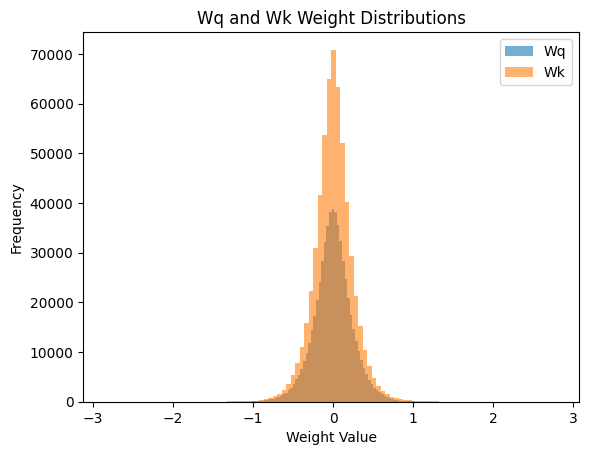

In [3]:
import matplotlib.pyplot as plt

# Wq, Wk weight 가져오기
Wq = attention.c_attn.weight[:, :model.config.n_embd]  # Query
Wk = attention.c_attn.weight[:, model.config.n_embd:2*model.config.n_embd]  # Key

# 통계 확인
print(f"Wq: mean={Wq.mean().item():.4f}, std={Wq.std().item():.4f}")
print(f"Wk: mean={Wk.mean().item():.4f}, std={Wk.std().item():.4f}")

# 히스토그램 시각화
plt.hist(Wq.flatten().detach().numpy(), bins=100, alpha=0.6, label='Wq')
plt.hist(Wk.flatten().detach().numpy(), bins=100, alpha=0.6, label='Wk')
plt.title("Wq and Wk Weight Distributions")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [7]:
import torch
from transformers import GPT2Model
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

# GPU 사용 가능 시 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GPT-2 모델 로드 (훈련된 weight 포함)
model = GPT2Model.from_pretrained("gpt2").to(device)
model.eval()

# 첫 번째 attention layer의 Wq, Wk weight 불러오기
attn = model.h[0].attn
d_model = model.config.n_embd  # 768 for gpt2 small

# Wq, Wk 분리
# c_attn shape: [3 * d_model, d_model]
W_all = attn.c_attn.weight.data  # [3*d_model, d_model]
Wq = W_all[:d_model].to(device)  # [d_model, d_model]
Wk = W_all[d_model:2*d_model].to(device)

# ----------------------------
# 시뮬레이션 파라미터 설정
# ----------------------------
num_samples = 1_000_000  # 충분히 큰 샘플 수
batch_size = 100_000     # 메모리 절약용 배치처리
logits_all = []

# ----------------------------
# 시뮬레이션 수행
# ----------------------------
for _ in range(num_samples // batch_size):
    x_i = torch.randn(batch_size, d_model, device=device)
    x_j = torch.randn(batch_size, d_model, device=device)

    q = x_i @ Wq.T  # [batch_size, d_model]
    k = x_j @ Wk.T

    dot = (q * k).sum(dim=1)  # 내적
    logits = dot / (d_model ** 0.5)
    logits_all.append(logits.cpu())

# 모든 배치 결합
logits_all = torch.cat(logits_all)

# ----------------------------
# 히스토그램 시각화
# ----------------------------
plt.figure(figsize=(10, 5))
plt.hist(logits_all.numpy(), bins=200, density=True, alpha=0.7, label='Empirical logits')

# 정규분포 기준선
x_vals = np.linspace(-5, 5, 300)
mu = logits_all.mean().item()
sigma = logits_all.std().item()
plt.plot(x_vals, norm.pdf(x_vals, mu, sigma), 'r--', label=f'N({mu:.2f}, {sigma:.2f}²)')

plt.title("Attention Logits Distribution (GPT-2 pretrained Wq, Wk)")
plt.xlabel("Logit Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# 통계 출력
# ----------------------------
print(f"Estimated attention logits ~ N(mean={mu:.4f}, std={sigma:.4f})")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100000x768 and 2304x768)

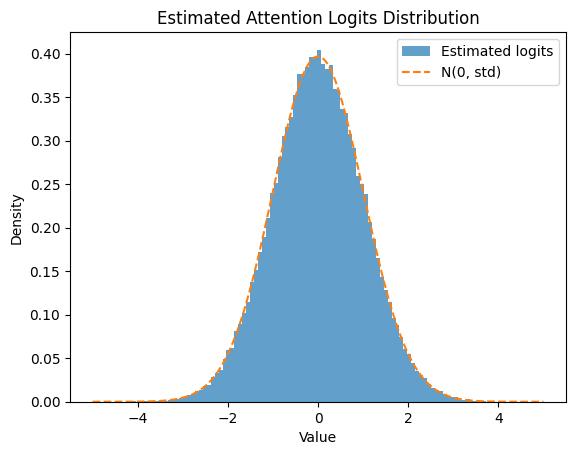

Estimated logits ~ N(mean=0.0048, std=1.0056)


In [5]:
import torch
import matplotlib.pyplot as plt

# 설정
d_model = 768  # GPT2 기본 모델 차원
num_samples = 100000  # 시뮬레이션 횟수

# Wq, Wk 무작위로 생성 (정규분포 기반, GPT2 weight 초기화 방식 비슷하게)
Wq = torch.randn(d_model, d_model) / (d_model ** 0.5)
Wk = torch.randn(d_model, d_model) / (d_model ** 0.5)

# 샘플 x ~ N(0, I)
x_i = torch.randn(num_samples, d_model)
x_j = torch.randn(num_samples, d_model)

# q = Wq x_i, k = Wk x_j
q = x_i @ Wq.T
k = x_j @ Wk.T

# attention logits z = (q ⋅ k) / sqrt(d_k)
dot_product = (q * k).sum(dim=1)
logits = dot_product / (d_model ** 0.5)

# 분포 시각화
plt.hist(logits.numpy(), bins=100, density=True, alpha=0.7, label='Estimated logits')
plt.title("Estimated Attention Logits Distribution")
plt.xlabel("Value")
plt.ylabel("Density")

# 정규분포 기준선 (mean=0, std≈1 expected)
import numpy as np
from scipy.stats import norm
x_vals = torch.linspace(-5, 5, 200).numpy()
plt.plot(x_vals, norm.pdf(x_vals, 0, logits.std().item()), label='N(0, std)', linestyle='--')
plt.legend()
plt.show()

# 통계 출력
print(f"Estimated logits ~ N(mean={logits.mean():.4f}, std={logits.std():.4f})")

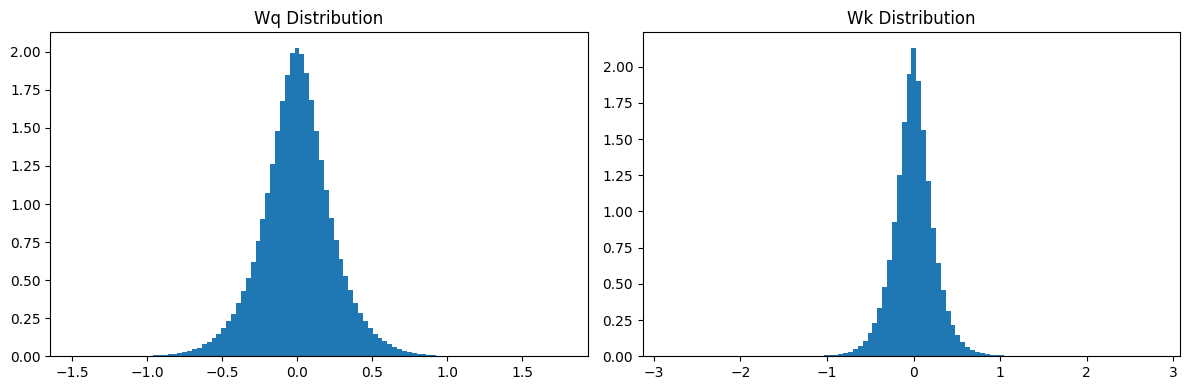

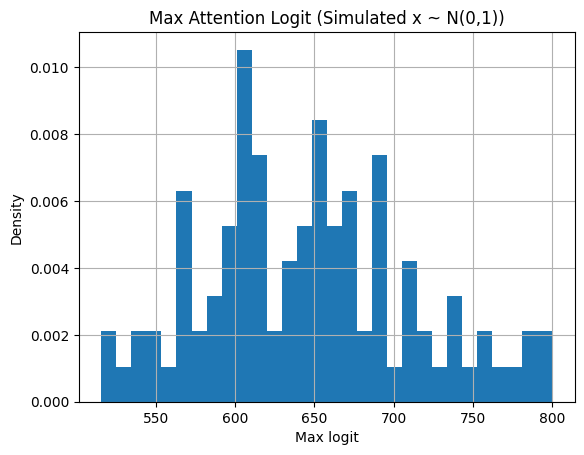

In [3]:
import torch
import matplotlib.pyplot as plt
from transformers import GPT2Model

# 모델 로딩 (첫 레이어만 사용)
model = GPT2Model.from_pretrained("gpt2")
model.eval()
layer = 0

attn = model.h[layer].attn
hidden = model.config.n_embd
num_heads = attn.num_heads
head_dim = hidden // num_heads

Wq = attn.c_attn.weight[:, :hidden].detach()
Wk = attn.c_attn.weight[:, hidden:2*hidden].detach()

# Wq, Wk 분포 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(Wq.cpu().numpy().flatten(), bins=100, density=True)
plt.title("Wq Distribution")

plt.subplot(1, 2, 2)
plt.hist(Wk.cpu().numpy().flatten(), bins=100, density=True)
plt.title("Wk Distribution")
plt.tight_layout()
plt.show()

# x ~ N(0,1) -> max(attn_logits) 분포 시뮬레이션
max_values = []
for _ in range(100):  # 더 늘릴 수 있음
    x = torch.randn(1, 10, hidden)  # [B, T, D]
    Q = x @ Wq
    K = x @ Wk
    Q = Q.view(1, 10, num_heads, head_dim).transpose(1, 2)  # [1, H, T, D]
    K = K.view(1, 10, num_heads, head_dim).transpose(1, 2)
    scores = Q @ K.transpose(-2, -1) / head_dim ** 0.5
    max_values.append(scores.max().item())

# 결과 시각화
plt.hist(max_values, bins=30, density=True)
plt.title("Max Attention Logit (Simulated x ~ N(0,1))")
plt.xlabel("Max logit")
plt.ylabel("Density")
plt.grid(True)
plt.show()


/home/pathfinder/miniconda3/envs/torch-env/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


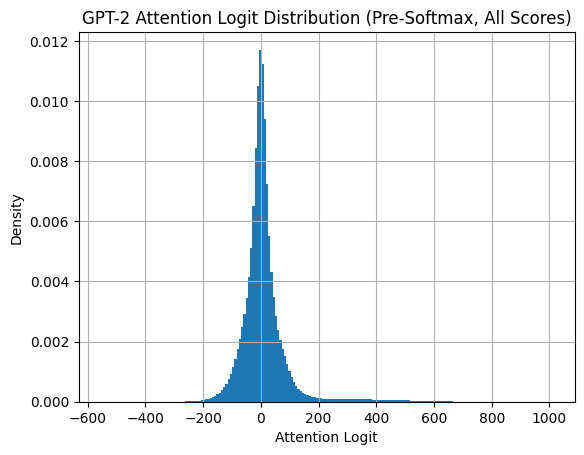

In [1]:
import torch
from transformers import GPT2Model
import matplotlib.pyplot as plt

# 1. GPT-2 모델 로드
model_name = "gpt2"
model = GPT2Model.from_pretrained(model_name)
model.eval()

# 2. LayerNorm 이후 입력 샘플링
def sample_normalized_x(seq_len, dim, batch_size):
    return torch.randn(batch_size, seq_len, dim)  # 평균 0, std 1 (LayerNorm 이후 가정)

# 3. 전체 Attention Score 추출
def get_attention_logits_all_gpt2(model, x, layer=0):
    attn = model.h[layer].attn  # GPT-2 attention module
    Wq = attn.c_attn.weight.data[:, :model.config.n_embd]  # Q
    Wk = attn.c_attn.weight.data[:, model.config.n_embd:2*model.config.n_embd]  # K

    # Q, K 계산
    Q = x @ Wq  # [B, T, D]
    K = x @ Wk  # [B, T, D]

    # Head 분리
    num_heads = attn.num_heads
    head_dim = model.config.n_embd // num_heads

    Q = Q.view(x.size(0), x.size(1), num_heads, head_dim).transpose(1, 2)  # [B, H, T, D]
    K = K.view(x.size(0), x.size(1), num_heads, head_dim).transpose(1, 2)  # [B, H, T, D]

    # Attention logits 계산
    attn_logits = Q @ K.transpose(-2, -1) / (head_dim ** 0.5)  # [B, H, T, T]

    return attn_logits.flatten().detach().cpu().numpy()  # 전체 분포 flatten

# 4. 분포 시각화
def simulate_and_plot_all_scores():
    seq_len = 10
    dim = model.config.n_embd
    batch_size = 64
    samples = []

    for _ in range(100):  # 반복 샘플링
        x = sample_normalized_x(seq_len, dim, batch_size)
        all_logits = get_attention_logits_all_gpt2(model, x, layer=0)
        samples.extend(all_logits)

    plt.hist(samples, bins=200, density=True)
    plt.title("GPT-2 Attention Logit Distribution (Pre-Softmax, All Scores)")
    plt.xlabel("Attention Logit")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

simulate_and_plot_all_scores()

In [2]:
from transformers import GPT2Model
model = GPT2Model.from_pretrained("gpt2")
Wq = model.h[0].attn.c_attn.weight[:, :768].flatten()
Wk = model.h[0].attn.c_attn.weight[:, 768:1536].flatten()
print(Wq.mean().item(), Wq.std().item())
print(Wk.mean().item(), Wk.std().item())

0.0001537436037324369 0.2386905699968338
1.2351187251624651e-05 0.2432965785264969
